## ***PART 1: Use sklearn & LDA models（just for comparison）***

This is different from the original version bcs changed to use a new train set. Just for comparison.

In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import make_pipeline
import numpy as np

train_df = pd.read_csv("new_reddit_train.csv")
sentences = train_df["sentence"].dropna().tolist()

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t.isalpha() and t not in stop_words]
    return " ".join(tokens)

processed_sentences = [preprocess(s) for s in sentences]

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2)
X = vectorizer.fit_transform(processed_sentences)

lda_model = LatentDirichletAllocation(n_components=3, random_state=42)  # 你有3类topic
lda_model.fit(X)

feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
    

topic_distributions = lda_model.transform(X)
predicted_topics = np.argmax(topic_distributions, axis=1)
train_df["lda_topic"] = predicted_topics

train_df.to_csv("new_reddit_train_with_lda.csv", index=False)

In [56]:
test_df = pd.read_csv("sentiment-topic-test.tsv", sep="\t")
test_sentences = test_df["sentence"].dropna().tolist()
test_processed = [preprocess(s) for s in test_sentences]
X_test = vectorizer.transform(test_processed)

test_topic_distributions = lda_model.transform(X_test)
test_predicted_topics = np.argmax(test_topic_distributions, axis=1)

test_df["lda_topic"] = test_predicted_topics
test_df.to_csv("test_set_with_lda_topic.csv", index=False)

lda_topic_to_label = {0: "movie", 1: "book", 2: "sports"}
test_df["lda_pred_label"] = test_df["lda_topic"].map(lda_topic_to_label)

print(test_df[["sentence", "topic", "lda_pred_label"]])

                                             sentence   topic lda_pred_label
0   The atmosphere at the stadium tonight was elec...  sports          movie
1   The game was so intense I forgot to breathe at...  sports          movie
2            It had me hooked from the first chapter.    book           book
3   It’s more of a slow burn than a page-turner, b...    book         sports
4   It’s split into two timelines, which keeps it ...    book           book
5   I could watch this film a hundred times and st...   movie           book
6   Best thriller I’ve seen in ages. Had me on the...   movie          movie
7   How do you concede three goals in ten minutes?...  sports         sports
8   They rotated their squad for the cup game, whi...  sports          movie
9   The trailer gave away most of the plot, but th...   movie           book
10  The protagonist was so whiny I wanted to throw...    book           book
11  The author’s writing style is so unique – poet...    book          movie

In [57]:
true_labels = test_df["topic"].tolist()
predicted_labels = test_df["lda_pred_label"].tolist()
print(classification_report(true_labels, predicted_labels, digits=2))

              precision    recall  f1-score   support

        book       0.44      0.67      0.53         6
       movie       0.17      0.17      0.17         6
      sports       0.67      0.33      0.44         6

    accuracy                           0.39        18
   macro avg       0.43      0.39      0.38        18
weighted avg       0.43      0.39      0.38        18



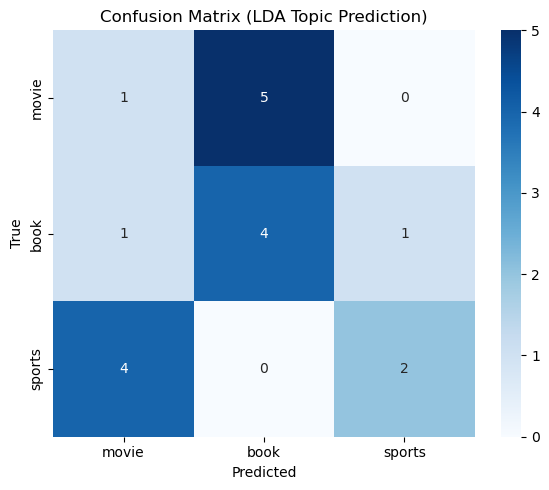

In [58]:
cm = confusion_matrix(true_labels, predicted_labels, labels=["movie", "book", "sports"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["movie", "book", "sports"],
            yticklabels=["movie", "book", "sports"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (LDA Topic Prediction)")
plt.tight_layout()
plt.show()

## ***PART2: BERT***

First, generate the train set from reddit base on type.

In [17]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from simpletransformers.classification import ClassificationModel, ClassificationArgs


D:\Anaconda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
!pip install praw
import praw
import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jbamb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [19]:
reddit = praw.Reddit(
    client_id="lgi7ajy0HKRKoCfprLPb4w",
    client_secret="1w958Fg5TVEUQdv4qOg4P30ayNYqqg",
    user_agent="Initial_Rhubarb_3701"
)

def get_sentences_from_subreddit(subreddit_name, topic_label, max_sentences=1000):
    subreddit = reddit.subreddit(subreddit_name)
    all_sentences = set()

    for submission in subreddit.hot(limit=100):  
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            sents = sent_tokenize(comment.body)
            for sent in sents:
                if 20 < len(sent) < 200:  # only choose sentence with proper length
                    all_sentences.add((sent.strip(), topic_label))
                    if len(all_sentences) >= max_sentences:
                        return list(all_sentences)
    return list(all_sentences)

movie_data = get_sentences_from_subreddit("movies", "movie")
book_data = get_sentences_from_subreddit("books", "book")
sports_data = get_sentences_from_subreddit("sports", "sports")

all_data = movie_data + book_data + sports_data
df = pd.DataFrame(all_data, columns=["sentence", "topic"])
df.to_csv("reddit_topic_sentences.csv", index=False)

print("got 3000 sentences in reddit_topic_sentences.csv")

got 3000 sentences in reddit_topic_sentences.csv


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
6it [01:21, 13.56s/it]                                                                                                 
chs 1/5. Running Loss:    1.0928:  18%|████████                                    | 31/169 [08:48<38:40, 16.81s/it]

0:00, ?it/s]

1it [00:31, 31.23s/it]

chs 1/5. Running Loss:    0.8982:  37%|████████████████▍                           | 63/169 [20:01<30:03, 17.02s/it]

0:00, ?it/s]

1it [00:30, 30.94s/it]

chs 1/5. Running Loss:    0.4381:  56%|████████████████████████▋                   | 95/169 [31:13<20:43, 16.80s/it]

0:00, ?it/s]

1it [00:32, 32.44s/it]

chs 1/5. Running Loss:    0.3959:  75%|████████████████████████████████▎          | 127/169 [42:28<11:52, 16.96s/it]

0:0

              precision    recall  f1-score   support

       movie       0.00      0.00      0.00         6
        book       0.45      0.83      0.59         6
      sports       0.86      1.00      0.92         6

    accuracy                           0.61        18
   macro avg       0.44      0.61      0.50        18
weighted avg       0.44      0.61      0.50        18



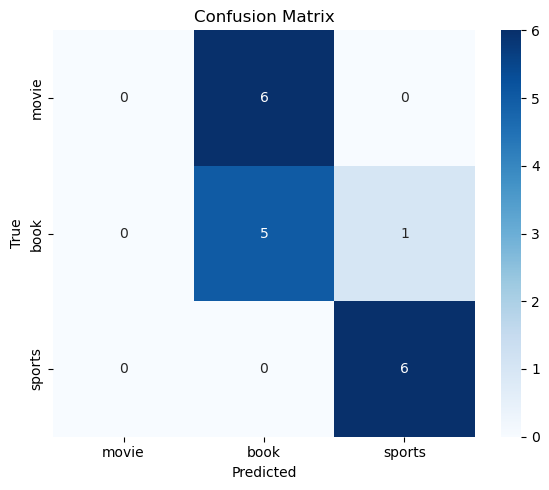

                                                 text true_topic  \
0   The atmosphere at the stadium tonight was elec...     sports   
1   The game was so intense I forgot to breathe at...     sports   
2            It had me hooked from the first chapter.       book   
3   It’s more of a slow burn than a page-turner, b...       book   
4   It’s split into two timelines, which keeps it ...       book   
5   I could watch this film a hundred times and st...      movie   
6   Best thriller I’ve seen in ages. Had me on the...      movie   
7   How do you concede three goals in ten minutes?...     sports   
8   They rotated their squad for the cup game, whi...     sports   
9   The trailer gave away most of the plot, but th...      movie   
10  The protagonist was so whiny I wanted to throw...       book   
11  The author’s writing style is so unique – poet...       book   
12  I don't get how was it supposed to work withou...      movie   
13  It's still 0-0 so far, so way too early to t

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from simpletransformers.classification import ClassificationModel, ClassificationArgs

train_df = pd.read_csv("reddit_topic_sentences.csv")
train_df = train_df.dropna(subset=['sentence', 'topic'])
train_df = train_df.rename(columns={'sentence': 'text', 'topic': 'labels'})

test_df = pd.read_csv("sentiment-topic-test.tsv", sep='\t')
test_df = test_df.dropna(subset=['sentence', 'topic'])
test_df = test_df.rename(columns={'sentence': 'text', 'topic': 'labels'})

all_labels = pd.concat([train_df['labels'], test_df['labels']]).unique().tolist()
topic2id = {topic: i for i, topic in enumerate(all_labels)}
id2topic = {i: topic for topic, i in topic2id.items()}

train_df['labels'] = train_df['labels'].map(topic2id)
test_df['labels'] = test_df['labels'].map(topic2id)

if train_df['labels'].nunique() >= 3 and len(train_df) * 0.1 >= train_df['labels'].nunique():
    train_data, dev_data = train_test_split(train_df, test_size=0.1, random_state=0, stratify=train_df[['labels']])
else:
    train_data, dev_data = train_test_split(train_df, test_size=0.1, random_state=0, shuffle=True)

model_args = ClassificationArgs()
model_args.num_train_epochs = 5
model_args.learning_rate = 2e-5
model_args.train_batch_size = 16
model_args.max_seq_length = 256
model_args.evaluate_during_training = True
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 2
model_args.evaluate_during_training_steps = 32
model_args.overwrite_output_dir = True
model_args.output_dir = "outputs"
model_args.use_early_stopping = True
model_args.early_stopping_patience = 1

model = ClassificationModel(
    model_type='bert',
    model_name='bert-base-cased',
    num_labels=len(topic2id),
    args=model_args,
    use_cuda=False
)

model.train_model(train_data, eval_df=dev_data)

predicted, _ = model.predict(test_df['text'].tolist())
test_df['predicted'] = predicted
test_df['predicted_topic'] = test_df['predicted'].map(id2topic)
test_df['true_topic'] = test_df['labels'].map(id2topic)

print(classification_report(test_df['labels'], predicted, target_names=id2topic.values()))

cm = confusion_matrix(test_df['labels'], predicted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2topic.values(), yticklabels=id2topic.values(), cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print(test_df[['text', 'true_topic', 'predicted_topic']])

errors = test_df[test_df['true_topic'] != test_df['predicted_topic']]
print(errors[['text', 'true_topic', 'predicted_topic']])

Adjusted learning rate and batch size twice but the movie topic still cannot be classificated. I guess maybe this is bcs of too less epoch so tried the fifth time.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
6it [01:21, 13.53s/it]                                                                                                 
chs 1/5. Running Loss:    1.0339:  18%|████████                                    | 31/169 [08:55<39:12, 17.05s/it]

0:00, ?it/s]

1it [00:38, 38.46s/it]

chs 1/5. Running Loss:    0.8030:  37%|████████████████▍                           | 63/169 [20:25<30:00, 16.98s/it]

0:00, ?it/s]

1it [00:31, 31.47s/it]

chs 1/5. Running Loss:    0.6515:  56%|████████████████████████▋                   | 95/169 [31:38<20:45, 16.84s/it]

0:00, ?it/s]

1it [00:30, 30.98s/it]

chs 1/5. Running Loss:    0.7763:  75%|████████████████████████████████▎          | 127/169 [42:52<11:54, 17.00s/it]

0:0

              precision    recall  f1-score   support

       movie       0.00      0.00      0.00         6
        book       0.45      0.83      0.59         6
      sports       0.86      1.00      0.92         6

    accuracy                           0.61        18
   macro avg       0.44      0.61      0.50        18
weighted avg       0.44      0.61      0.50        18



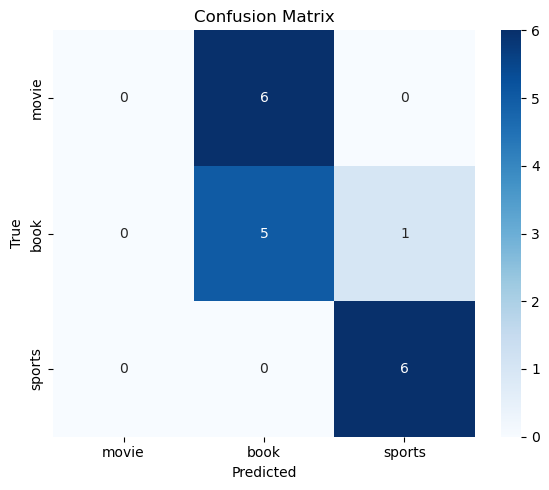

                                                 text true_topic  \
0   The atmosphere at the stadium tonight was elec...     sports   
1   The game was so intense I forgot to breathe at...     sports   
2            It had me hooked from the first chapter.       book   
3   It’s more of a slow burn than a page-turner, b...       book   
4   It’s split into two timelines, which keeps it ...       book   
5   I could watch this film a hundred times and st...      movie   
6   Best thriller I’ve seen in ages. Had me on the...      movie   
7   How do you concede three goals in ten minutes?...     sports   
8   They rotated their squad for the cup game, whi...     sports   
9   The trailer gave away most of the plot, but th...      movie   
10  The protagonist was so whiny I wanted to throw...       book   
11  The author’s writing style is so unique – poet...       book   
12  I don't get how was it supposed to work withou...      movie   
13  It's still 0-0 so far, so way too early to t

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from simpletransformers.classification import ClassificationModel, ClassificationArgs

train_df = pd.read_csv("reddit_topic_sentences.csv")
train_df = train_df.dropna(subset=['sentence', 'topic'])
train_df = train_df.rename(columns={'sentence': 'text', 'topic': 'labels'})

test_df = pd.read_csv("sentiment-topic-test.tsv", sep='\t')
test_df = test_df.dropna(subset=['sentence', 'topic'])
test_df = test_df.rename(columns={'sentence': 'text', 'topic': 'labels'})

all_labels = pd.concat([train_df['labels'], test_df['labels']]).unique().tolist()
topic2id = {topic: i for i, topic in enumerate(all_labels)}
id2topic = {i: topic for topic, i in topic2id.items()}

train_df['labels'] = train_df['labels'].map(topic2id)
test_df['labels'] = test_df['labels'].map(topic2id)

if train_df['labels'].nunique() >= 3 and len(train_df) * 0.1 >= train_df['labels'].nunique():
    train_data, dev_data = train_test_split(train_df, test_size=0.1, random_state=0, stratify=train_df[['labels']])
else:
    train_data, dev_data = train_test_split(train_df, test_size=0.1, random_state=0, shuffle=True)

model_args = ClassificationArgs()
model_args.num_train_epochs = 5
model_args.learning_rate = 2e-5
model_args.train_batch_size = 16
model_args.max_seq_length = 256
model_args.evaluate_during_training = True
model_args.use_early_stopping = True
model_args.early_stopping_delta = 0.01
model_args.early_stopping_metric = 'eval_loss'
model_args.early_stopping_metric_minimize = True
model_args.early_stopping_patience = 3
model_args.evaluate_during_training_steps = 32
model_args.overwrite_output_dir = True
model_args.output_dir = "outputs"


model = ClassificationModel(
    model_type='bert',
    model_name='bert-base-cased',
    num_labels=len(topic2id),
    args=model_args,
    use_cuda=False
)

model.train_model(train_data, eval_df=dev_data)

predicted, _ = model.predict(test_df['text'].tolist())
test_df['predicted'] = predicted
test_df['predicted_topic'] = test_df['predicted'].map(id2topic)
test_df['true_topic'] = test_df['labels'].map(id2topic)

print(classification_report(test_df['labels'], predicted, target_names=id2topic.values()))

cm = confusion_matrix(test_df['labels'], predicted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2topic.values(), yticklabels=id2topic.values(), cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

print(test_df[['text', 'true_topic', 'predicted_topic']])

errors = test_df[test_df['true_topic'] != test_df['predicted_topic']]
print(errors[['text', 'true_topic', 'predicted_topic']])

## ***Incremental training***

Then I check the dataset and realise that the train dataset has its limitation. So I decide to do continued fine-tuning.

I gave some film titles to more accurately get reviews related to the film topic and used this new dataset of 300 entries for incremental training to see if the results would be different.

In [38]:
import requests
import praw
from nltk.tokenize import sent_tokenize
import time

def get_movie_sentences_by_keyword(keywords, topic_label="movie", max_sentences=300):
    all_sentences = set()
    for kw in keywords:
        subreddit = reddit.subreddit("all")
        for submission in subreddit.search(kw, sort="relevance", limit=30):
            submission.comments.replace_more(limit=0)
            for comment in submission.comments.list():
                sents = sent_tokenize(comment.body)
                for sent in sents:
                    if 20 < len(sent) < 200:
                        all_sentences.add((sent.strip(), topic_label))
                        if len(all_sentences) >= max_sentences:
                            return list(all_sentences)
    return list(all_sentences)

movie_keywords = ["Dune", "Oppenheimer", "Interstellar", "Barbie", "Avengers", "Spider-Man"]
extra_movie_data = get_movie_sentences_by_keyword(movie_keywords)

df_extra = pd.DataFrame(extra_movie_data, columns=["sentence", "topic"])
df_extra.to_csv("reddit_movie_extra.csv", index=False)

print("new 300 movie topic in reddit_movie_extra.csv")

new 300 movie topic in reddit_movie_extra.csv


1it [00:37, 37.51s/it]
Epoch 2 of 2: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [05:26<00:00, 163.33s/it]
1it [00:30, 30.80s/it]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.89s/it]


              precision    recall  f1-score   support

       movie       1.00      0.50      0.67         6
        book       0.62      0.83      0.71         6
      sports       0.86      1.00      0.92         6

    accuracy                           0.78        18
   macro avg       0.83      0.78      0.77        18
weighted avg       0.83      0.78      0.77        18



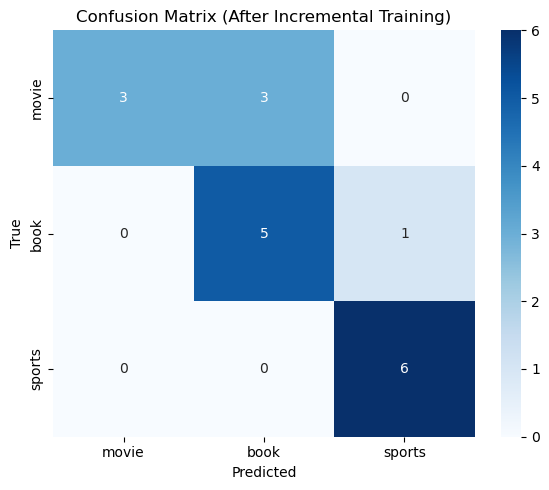

In [40]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from simpletransformers.classification import ClassificationModel, ClassificationArgs

extra_movie_df = pd.read_csv("reddit_movie_extra.csv").dropna(subset=['sentence', 'topic'])
extra_movie_df = extra_movie_df.rename(columns={'sentence': 'text', 'topic': 'labels'})

extra_movie_df['labels'] = extra_movie_df['labels'].map(topic2id)

model_args = ClassificationArgs()
model_args.num_train_epochs = 2  
model_args.learning_rate = 1e-6  
model_args.train_batch_size = 16
model_args.evaluate_during_training = False
model_args.use_early_stopping = True
model_args.early_stopping_patience = 2
model_args.evaluate_during_training_steps = 16
model_args.overwrite_output_dir = True  
model_args.output_dir = "outputs/incremental"

model = ClassificationModel(
    model_type='bert',
    model_name='outputs/best_model', 
    num_labels=len(topic2id),
    args=model_args,
    use_cuda=False
)

model.train_model(extra_movie_df)

predicted, _ = model.predict(test_df['text'].tolist())
test_df['predicted'] = predicted
test_df['predicted_topic'] = test_df['predicted'].map(id2topic)

print(classification_report(test_df['labels'], predicted, target_names=id2topic.values()))

cm = confusion_matrix(test_df['labels'], predicted)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2topic.values(), yticklabels=id2topic.values(), cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (After Incremental Training)")
plt.tight_layout()
plt.show()

So we can infer that the previous poor performance of movie's prediction is due to the problem of insufficient precision of the training dataset.

Overall, the model performs very well in the sports category, with near perfect precision and recall. However, recall is low in the film category, resulting in a relatively poor F1 score. The performance in the Books category is relatively balanced, with high recall despite low precision. The classification of the movie and book categories can be improved in the future by further optimising the model by adjusting the hyperparameters, increasing the training data or using a stronger model, especially in terms of the balance between recall and precision.